In [1]:
!pip install pyspark==3.1.2 spark-nlp==3.3.1
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash /dev/stdin -p 3.2.3 -s 5.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 20.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880745 sha256=e003e4d147382592414493192b806cb6c64d5d38949b2c60490dc37eb5d2bdc3
  Stored in directory: /root/.cache/pip/wheels/ef/70/50/7882e1bcb5693225f7cc86698f10953201b48b3f36317c2d18
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
--2024-03-27 02:04:48--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting r

In [2]:
# these line are used to load the Google drive into the notebook
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/Colab Notebooks/"  # this is your drive

Mounted at /content/drive/


## Create SparkNLP

In [3]:
from pyspark.sql import SparkSession
import sparknlp

ss = sparknlp.start()

# Importing Dataset

In [4]:
# read .csv file
df = ss.read.csv(data_path + 'comments.csv', inferSchema=True, header=True)
# there will be error if we use spark to load the csv file directly
df.show(10, False)  # to see the whole comment content

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+
|Comment                                                                                                                                                             |Sentiment              |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+
|Dissapointed you did not animate a 13000-dimensional graph. Would make things easier                                                                                |0                      |
|Theory: Karl is a creation made by the dev that was supposed to help you but has gone wrong and is trying to hunt the players and scare them                        |0                      |
|"There is no ""loop hole"" for how Death Str

In [5]:
import pandas as pd

# use Pandas to load the csv file
file_path = data_path + '/comments.csv'
pd_df = pd.read_csv(file_path)

# convert Pandas DataFrame to PySpark DataFrame
df = ss.createDataFrame(pd_df)
df.show(10, False)  # to see the whole comment content

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Visualization1

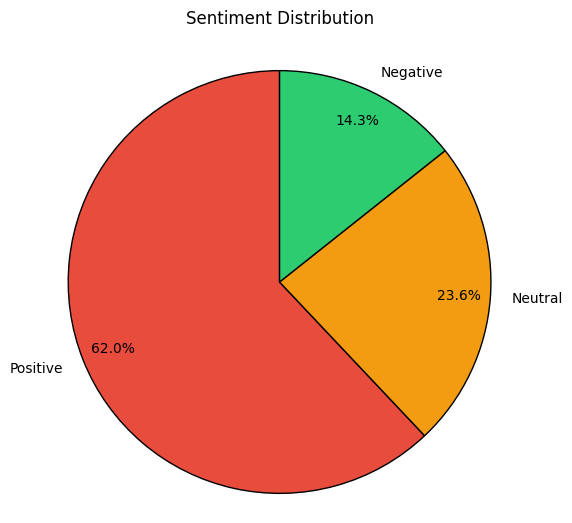

In [6]:
import matplotlib.pyplot as plt

# select the variable to be displayed in Pie chart
data1 = df.select('Comment').toPandas()

# Count the number in the sentiment and plot the percentage
sentiment_counts = df.select('Sentiment').toPandas().value_counts()

labels = ['Positive', 'Neutral', 'Negative']
colors = ['#e74c3c', '#f39c12', '#2ecc71']

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85,
        wedgeprops={"edgecolor":"0",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

plt.axis('equal')
plt.title('Sentiment Distribution', pad=20)
plt.show()

# Visualization2

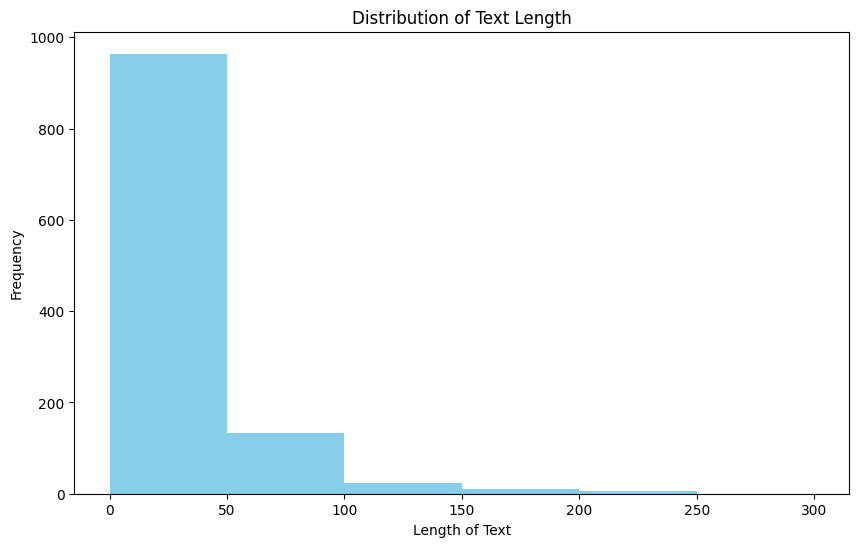

In [7]:
from pyspark.sql.functions import split, size
import numpy as np

# count the number of words in each comment
data = df.withColumn("length", size(split(df["Comment"], " ")))

# convert to Pandas DataFrame
length_pd = data.select("length").toPandas()

bins = np.arange(0, 350, 50) # the range for x-axis, 1 to 350, every 50 as a unit

plt.figure(figsize=(10, 6))
plt.hist(length_pd['length'], bins, color='skyblue')
plt.title('Distribution of Text Length')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

# Visualization3

In [8]:
!pip install wordcloud

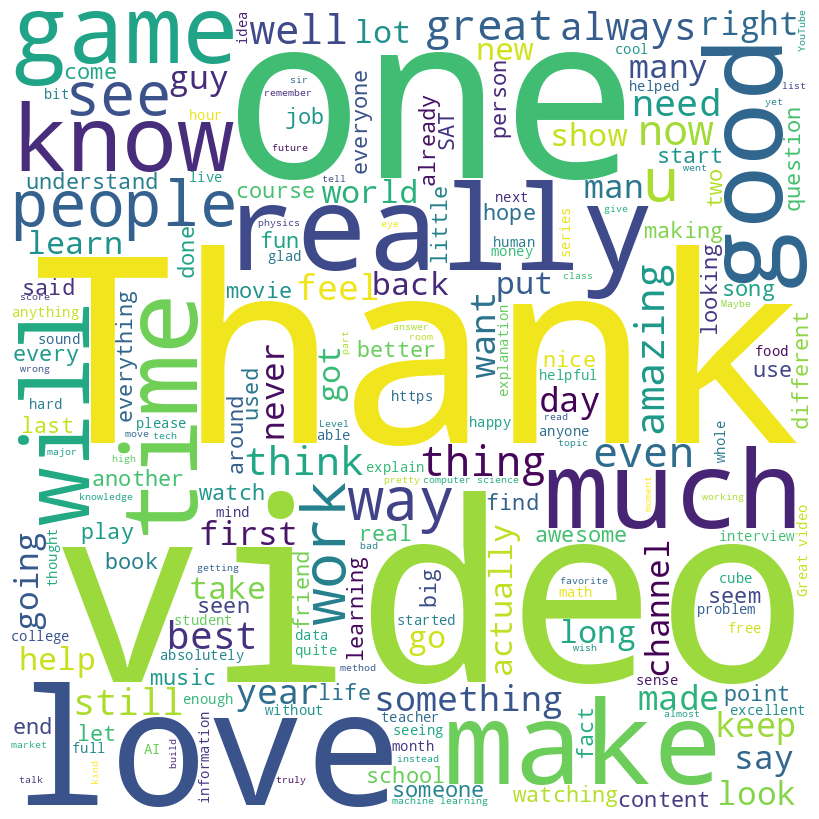

In [9]:
from wordcloud import WordCloud
from pyspark.sql.functions import collect_list

comments_list = data.select(collect_list("Comment")).first()[0]

# combine all comments in the list into one long string
text = " ".join(comment for comment in comments_list)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Visualization4

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


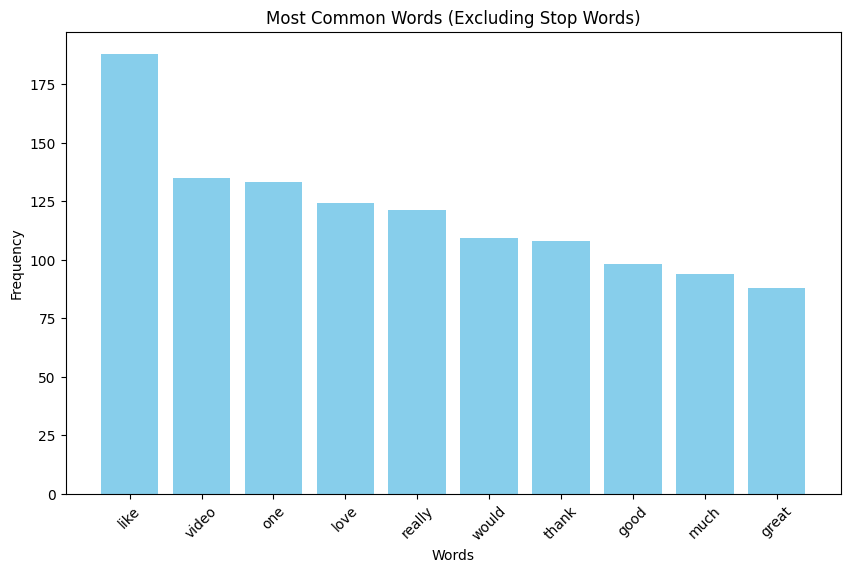

In [12]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql.functions import explode
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# define stop words
stop_words = set(stopwords.words('english'))

# define UDF for text processing: convert to lowercase, word segmentation, filter stop words
def process_text(text):
    words = re.split("\W+", text.lower())  # word segmentation and conversion to lower case
    meaningful_words = [word for word in words if word not in stop_words and word != '']  # filter stop words
    return meaningful_words

process_text_udf = udf(process_text, ArrayType(StringType()))

# apply UDF to each comment
data_processed = df.withColumn("meaningful_words", process_text_udf(df["Comment"]))

# expand the vocabulary column and count the occurrences of each word
data_exploded = data_processed.withColumn("word", explode(data_processed["meaningful_words"]))
word_counts = data_exploded.groupBy("word").count()

# get the most frequently occurring words
most_common_words = word_counts.orderBy("count", ascending=False).limit(10)

# collect data for plotting
common_words_data = most_common_words.collect()
words, frequencies = zip(*[(row['word'], row['count']) for row in common_words_data])

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.title('Most Common Words (Excluding Stop Words)')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

# Visualization5

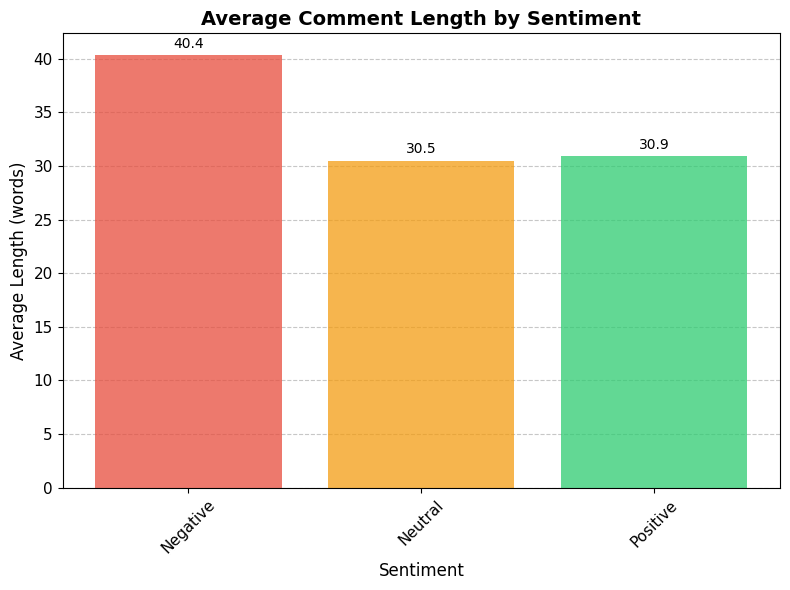

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, size, avg, col
import matplotlib.pyplot as plt

# calculate the length of each comment
data = df.withColumn("Length", size(split(col("Comment"), " ")))

# calculate average comment length based on sentiment value
average_lengths = data.groupBy("Sentiment").agg(avg("Length").alias("AverageLength"))

# convert results to Pandas DataFrame for plotting
average_lengths_pd = average_lengths.toPandas()

# mapping numeric labels to emotion labels
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
average_lengths_pd['Sentiment'] = average_lengths_pd['Sentiment'].map(sentiment_labels)

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(average_lengths_pd['Sentiment'], average_lengths_pd['AverageLength'], color=['#e74c3c', '#f39c12', '#2ecc71'], alpha=0.75)

ax.set_title('Average Comment Length by Sentiment', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Average Length (words)', fontsize=12)

for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.1f}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.set_axisbelow(True)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

# Baseline Model——LogisticRegression

## Splitting Data

In [14]:
# split the data into training and test sets (20% held out for testing)
# seed = 1234
(train_set, test_set) = df.randomSplit([0.8, 0.2], seed=1234)

## TF-IDF Processing and Modelling

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer
from pyspark.ml.classification import LogisticRegression


# define the tokenizer and CountVectorizer
tokenizer = Tokenizer(inputCol="Comment", outputCol="words") # Tokenizer split each document to words by space
tf_  = CountVectorizer(inputCol="words", outputCol="tf") # CountVectorizer count word freq of each doc
idf_ = IDF(inputCol="tf", outputCol="tfidf_features")
lr = LogisticRegression(featuresCol = 'tfidf_features', labelCol = 'Sentiment')

pipeline = Pipeline(stages=[tokenizer, tf_, idf_, lr])

# fit and transform model: build model and apply on data
# when using PySpark's LogisticRegression model, the output DataFrame will contain several additional columns: rawPrediction, probability, and prediction.
baseline_tfidf_model = pipeline.fit(train_set)
baseline_tfidf_model_predictions = baseline_tfidf_model.transform(test_set)
baseline_tfidf_model_predictions.show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Evaluation

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy_baseline_tfidf = evaluator.evaluate(baseline_tfidf_model_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1_baseline_tfidf = evaluator.evaluate(baseline_tfidf_model_predictions)

print(f"Model's F1-score: {f1_baseline_tfidf}")
print(f"Model's Accuracy: {accuracy_baseline_tfidf * 100}%")

Model's F1-score: 0.5846804843139353
Model's Accuracy: 63.47826086956522%


# Compared Modelling

## SVM with One-vs-Rest

In [17]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import OneVsRest

# initialize SVM model
svm = LinearSVC()

# use the OneVsRest strategy
ovr = OneVsRest(classifier=svm, featuresCol='tfidf_features', labelCol='Sentiment')

# create a Pipeline containing text processing and OneVsRest
pipeline_ovr = Pipeline(stages=[tokenizer, tf_, idf_, ovr])

# train the model
svm_ovr_tfidf_model = pipeline_ovr.fit(train_set)

# use the model to make predictions
svm_ovr_tfidf_model_predictions = svm_ovr_tfidf_model.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy_svm_ovr_tfidf = evaluator.evaluate(svm_ovr_tfidf_model_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1_svm_ovr_tfidf = evaluator.evaluate(svm_ovr_tfidf_model_predictions)

print(f"One-vs-Rest SVM Model's F1-score: {f1_svm_ovr_tfidf}")
print(f"One-vs-Rest SVM Model's Accuracy: {accuracy_svm_ovr_tfidf * 100}%")

One-vs-Rest SVM Model's F1-score: 0.5878713912581188
One-vs-Rest SVM Model's Accuracy: 62.17391304347826%


## Random Forest

In [18]:
from pyspark.ml.classification import RandomForestClassifier

# initialize Random Forest model
rf = RandomForestClassifier(featuresCol='tfidf_features', labelCol='Sentiment')

# create a Pipeline containing text processing and Random Forest
pipeline_rf = Pipeline(stages=[tokenizer, tf_, idf_, rf])

# train the model
rf_tfidf_model = pipeline_rf.fit(train_set)

# use the model to make predictions
rf_tfidf_model_predictions = rf_tfidf_model.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy_rf_tfidf = evaluator.evaluate(rf_tfidf_model_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1_rf_tfidf = evaluator.evaluate(rf_tfidf_model_predictions)

print(f"Random Forest Model's F1-score: {f1_rf_tfidf}")
print(f"Random Forest Model's Accuracy: {accuracy_rf_tfidf * 100}%")

Random Forest Model's F1-score: 0.4553081182985743
Random Forest Model's Accuracy: 60.43478260869565%


## Naive Bayes classifier

In [19]:
from pyspark.ml.classification import NaiveBayes

# initialize Naive Bayes model
nb = NaiveBayes(featuresCol='tfidf_features', labelCol='Sentiment')

# create a Pipeline containing text processing and Random Forest
pipeline_nb = Pipeline(stages=[tokenizer, tf_, idf_, nb])

# train the model
nb_tfidf_model = pipeline_nb.fit(train_set)

# use the model to make predictions
nb_tfidf_model_predictions = nb_tfidf_model.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy_nb_tfidf = evaluator.evaluate(nb_tfidf_model_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1_nb_tfidf = evaluator.evaluate(nb_tfidf_model_predictions)

print(f"Naive Bayes Model's F1-score: {f1_nb_tfidf}")
print(f"Naive Bayes Model's Accuracy: {accuracy_nb_tfidf * 100}%")

Naive Bayes Model's F1-score: 0.6367287468025109
Naive Bayes Model's Accuracy: 64.78260869565217%


# Fine-Tune Model

## Data Analytics Models

### SVM with One-vs-Rest

In [20]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# create ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.1, 1, 10, 100]) \
    .addGrid(svm.maxIter, [100, 200]) \
    .addGrid(svm.tol, [1e-4, 1e-5, 1e-6]) \
    .build()

# use f1 score to do the cross validation
crossval = CrossValidator(estimator=pipeline_ovr,
              estimatorParamMaps=paramGrid,
              evaluator=MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1"),
              numFolds=5)

cvModel = crossval.fit(train_set)
best_svm_ovr_predictions = cvModel.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
best_accuracy_svm_ovr_tfidf = evaluator.evaluate(best_svm_ovr_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
best_f1_svm_ovr_tfidf = evaluator.evaluate(best_svm_ovr_predictions)

print(f"One-vs-Rest SVM Model's F1-score: {best_f1_svm_ovr_tfidf}")
print(f"One-vs-Rest SVM Model's Accuracy: {best_accuracy_svm_ovr_tfidf * 100}%")

One-vs-Rest SVM Model's F1-score: 0.5965763419264745
One-vs-Rest SVM Model's Accuracy: 64.34782608695652%


### Random Forest

In [21]:
# create ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .addGrid(rf.minInstancesPerNode, [1, 2]) \
    .addGrid(rf.minInfoGain, [0.0, 0.1]) \
    .build()

# use f1 score to do the cross validation
crossval = CrossValidator(estimator=pipeline_rf,
              estimatorParamMaps=paramGrid,
              evaluator=MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1"),
              numFolds=5)

cvModel = crossval.fit(train_set)
best_rf_predictions = cvModel.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
best_accuracy_rf_tfidf = evaluator.evaluate(best_rf_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
best_f1_rf_tfidf = evaluator.evaluate(best_rf_predictions)

print(f"Random Forest Model's F1-score: {best_f1_rf_tfidf}")
print(f"Random Forest Model's Accuracy: {best_accuracy_rf_tfidf * 100}%")

Random Forest Model's F1-score: 0.4553081182985743
Random Forest Model's Accuracy: 60.43478260869565%


### Naive Bayes classifier

In [22]:
# create ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 2.0]) \
    .build()

# use f1 score to do the cross validation
crossval = CrossValidator(estimator=pipeline_nb,
              estimatorParamMaps=paramGrid,
              evaluator=MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1"),
              numFolds=5)

cvModel = crossval.fit(train_set)
best_nb_predictions = cvModel.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
best_accuracy_nb_tfidf = evaluator.evaluate(best_nb_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
best_f1_nb_tfidf = evaluator.evaluate(best_nb_predictions)

print(f"Naive Bayes Model's F1-score: {best_f1_nb_tfidf}")
print(f"Naive Bayes Model's Accuracy: {best_accuracy_nb_tfidf * 100}%")

Naive Bayes Model's F1-score: 0.6367287468025109
Naive Bayes Model's Accuracy: 64.78260869565217%


# Improving Baseline Model

## Cleaning Comment

In [23]:
# Preprocess the text
from sparknlp.base import *
from sparknlp.annotator import *

# Spark NLP component
assembler = DocumentAssembler()\
    .setInputCol("Comment")\
    .setOutputCol("document")

sentence_detector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

sparknlp_tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

normalizer = Normalizer()\
    .setInputCols(["token"])\
    .setOutputCol("normalized")\
    .setLowercase(True)

finisher = Finisher()\
    .setInputCols(["normalized"])\
    .setOutputCols(["token_features"])\
    .setOutputAsArray(True)

# PySpark ML component
tf_ = CountVectorizer(inputCol="token_features", outputCol="tf")
idf_ = IDF(inputCol="tf", outputCol="tfidf_features")
lr = LogisticRegression(featuresCol = 'tfidf_features', labelCol = 'Sentiment')

# create Pipeline
pipeline_cl = Pipeline(stages=[
    assembler,
    sentence_detector,
    sparknlp_tokenizer,
    normalizer,
    finisher,
    tf_,
    idf_,
    lr
])

In [24]:
# train the model
# train_set and test_set again
cleaned_baseline_tfidf_model = pipeline_cl.fit(train_set)

# use the model to make predictions
cleaned_baseline_tfidf_predictions = cleaned_baseline_tfidf_model.transform(test_set)

# show the cleaned
cleaned_baseline_tfidf_predictions.show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy_cleaned_baseline_tfidf = evaluator.evaluate(cleaned_baseline_tfidf_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1_cleaned_baseline_tfidf = evaluator.evaluate(cleaned_baseline_tfidf_predictions)

print(f"Cleaned Baseline Model's F1-score: {f1_cleaned_baseline_tfidf}")
print(f"Cleaned Baseline Model's Accuracy: {accuracy_cleaned_baseline_tfidf * 100}%")

Cleaned Baseline Model's F1-score: 0.5926954048193981
Cleaned Baseline Model's Accuracy: 62.60869565217392%


## Try different processing model

### HashingTF

In [26]:
from pyspark.ml.feature import HashingTF
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer
from pyspark.ml.classification import LogisticRegression

tokenizer = Tokenizer(inputCol="Comment", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="hashingTF_features")
lr = LogisticRegression(featuresCol="hashingTF_features", labelCol="Sentiment")

pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# fit and transform model: build model and apply on data
baseline_hashingtf_model = pipeline.fit(train_set)
baseline_hashingtf_predictions = baseline_hashingtf_model.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy_baseline_hashingtf = evaluator.evaluate(baseline_hashingtf_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1_baseline_hashingtf = evaluator.evaluate(baseline_hashingtf_predictions)

print(f"HashingTF Baseline Model's F1-score: {f1_baseline_hashingtf}")
print(f"HashingTF Baseline Model's Accuracy: {accuracy_baseline_hashingtf * 100}%")

HashingTF Baseline Model's F1-score: 0.5750456731672597
HashingTF Baseline Model's Accuracy: 62.60869565217392%


#### Cleaning Comment

In [27]:
# Preprocess the text
from sparknlp.base import *
from sparknlp.annotator import *

# Spark NLP component
assembler = DocumentAssembler()\
    .setInputCol("Comment")\
    .setOutputCol("document")

sentence_detector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

sparknlp_tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

normalizer = Normalizer()\
    .setInputCols(["token"])\
    .setOutputCol("normalized")\
    .setLowercase(True)

finisher = Finisher()\
    .setInputCols(["normalized"])\
    .setOutputCols(["token_features"])\
    .setOutputAsArray(True)

# PySpark ML component
hashingTF = HashingTF(inputCol="token_features", outputCol="hashingTF_features")
lr = LogisticRegression(featuresCol = 'hashingTF_features', labelCol = 'Sentiment')

# create Pipeline
pipeline_cl = Pipeline(stages=[
    assembler,
    sentence_detector,
    sparknlp_tokenizer,
    normalizer,
    finisher,
    hashingTF,
    lr
])

# train the model
# train_set and test_set again
cleaned_baseline_hashingtf_model = pipeline_cl.fit(train_set)

# use the model to make predictions
cleaned_baseline_hashingtf_predictions = cleaned_baseline_hashingtf_model.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy_cleaned_baseline_hashingtf = evaluator.evaluate(cleaned_baseline_hashingtf_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1_cleaned_baseline_hashingtf = evaluator.evaluate(cleaned_baseline_hashingtf_predictions)

print(f"Cleaned HashingTF Baseline Model's F1-score: {f1_cleaned_baseline_hashingtf}")
print(f"Cleaned HashingTF Baseline Model's Accuracy: {accuracy_cleaned_baseline_hashingtf * 100}%")

Cleaned HashingTF Baseline Model's F1-score: 0.5772538259172301
Cleaned HashingTF Baseline Model's Accuracy: 61.73913043478261%


### Word2Vec

In [28]:
from pyspark.ml.feature import Word2Vec, Tokenizer

tokenizer = Tokenizer(inputCol="Comment", outputCol="words")

word2Vec = Word2Vec(inputCol="words", outputCol="w2v")

# initialize the model
lr_w2v = LogisticRegression(featuresCol="w2v", labelCol="Sentiment")

# define Pipeline
pipeline = Pipeline(stages=[tokenizer, word2Vec, lr_w2v])

# use same splitted dataset to train model
baseline_w2v_model = pipeline.fit(train_set)

# use the model to make predictions
baseline_w2v_model_predictions = baseline_w2v_model.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy_baseline_w2v = evaluator.evaluate(baseline_w2v_model_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1_baseline_w2v = evaluator.evaluate(baseline_w2v_model_predictions)

print(f"Word2Vec + Logistic Regression Model's F1-score: {f1_baseline_w2v}")
print(f"Word2Vec + Logistic Regression Model's Accuracy: {accuracy_baseline_w2v * 100}%")

Word2Vec + Logistic Regression Model's F1-score: 0.6215913887716337
Word2Vec + Logistic Regression Model's Accuracy: 65.65217391304347%


#### Cleaning Comment

In [29]:
# Preprocess the text
from sparknlp.base import *
from sparknlp.annotator import *

# Spark NLP component
assembler = DocumentAssembler()\
    .setInputCol("Comment")\
    .setOutputCol("document")

sentence_detector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

sparknlp_tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

normalizer = Normalizer()\
    .setInputCols(["token"])\
    .setOutputCol("normalized")\
    .setLowercase(True)

finisher = Finisher()\
    .setInputCols(["normalized"])\
    .setOutputCols(["token_features"])\
    .setOutputAsArray(True)

word2Vec = Word2Vec(inputCol="token_features", outputCol="w2v")

lr_w2v = LogisticRegression(featuresCol="w2v", labelCol="Sentiment")

# create Pipeline
pipeline_cl = Pipeline(stages=[
    assembler,
    sentence_detector,
    sparknlp_tokenizer,
    normalizer,
    finisher,
    word2Vec,
    lr_w2v
])

cleaned_baseline_w2v_model = pipeline_cl.fit(train_set)

# use the model to make predictions
cleaned_baseline_w2v_predictions = cleaned_baseline_w2v_model.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy_cleaned_baseline_w2v = evaluator.evaluate(cleaned_baseline_w2v_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1_cleaned_baseline_w2v = evaluator.evaluate(cleaned_baseline_w2v_predictions)

print(f"Cleaned Word2Vec Baseline Model's F1-score: {f1_cleaned_baseline_w2v}")
print(f"Cleaned Word2Vec Baseline Model's Accuracy: {accuracy_cleaned_baseline_w2v * 100}%")

Cleaned Word2Vec Baseline Model's F1-score: 0.6299195269551514
Cleaned Word2Vec Baseline Model's Accuracy: 65.21739130434783%


### N-grams

In [30]:
from pyspark.ml.feature import NGram, Tokenizer

# Tokenization
tokenizer = Tokenizer(inputCol="Comment", outputCol="words")

# n-gram Transformer
ngram = NGram(n=2, inputCol="words", outputCol="ngrams")

cv = CountVectorizer(inputCol="ngrams", outputCol="features")

lr = LogisticRegression(featuresCol="features", labelCol="Sentiment")

# Pipeline
pipeline = Pipeline(stages=[tokenizer, ngram, cv, lr])

baseline_ngrams_model = pipeline.fit(train_set)
baseline_ngrams_model_predictions = baseline_ngrams_model.transform(test_set)

# evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy_baseline_ngrams = evaluator.evaluate(baseline_ngrams_model_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1_baseline_ngrams = evaluator.evaluate(baseline_ngrams_model_predictions)

print(f"Word2Vec + Logistic Regression Model's F1-score: {f1_baseline_ngrams}")
print(f"Word2Vec + Logistic Regression Model's Accuracy: {accuracy_baseline_ngrams * 100}%")

Word2Vec + Logistic Regression Model's F1-score: 0.5375990586808538
Word2Vec + Logistic Regression Model's Accuracy: 59.130434782608695%


## Best Baseline Model

In [33]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

tokenizer = Tokenizer(inputCol="Comment", outputCol="words")
word2Vec = Word2Vec(inputCol="words", outputCol="w2v")
lr_w2v = LogisticRegression(featuresCol="w2v", labelCol="Sentiment")
pipeline = Pipeline(stages=[tokenizer, word2Vec, lr_w2v])

# ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(word2Vec.vectorSize, [100, 200]) \
    .addGrid(word2Vec.minCount, [1, 5]) \
    .addGrid(lr_w2v.regParam, [0.01, 0.1]) \
    .addGrid(lr_w2v.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1"),
                          numFolds=3)

cvModel = crossval.fit(train_set)

predictions = cvModel.transform(test_set)

evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Optimized Word2Vec + Logistic Regression Model's F1-score: {f1}")
print(f"Optimized Word2Vec + Logistic Regression Model's accuray: {accuracy * 100}%")

Optimized Word2Vec + Logistic Regression Model's F1-score: 0.5751551930265288
Optimized Word2Vec + Logistic Regression Model's accuray: 65.21739130434783%


# Visualization 6

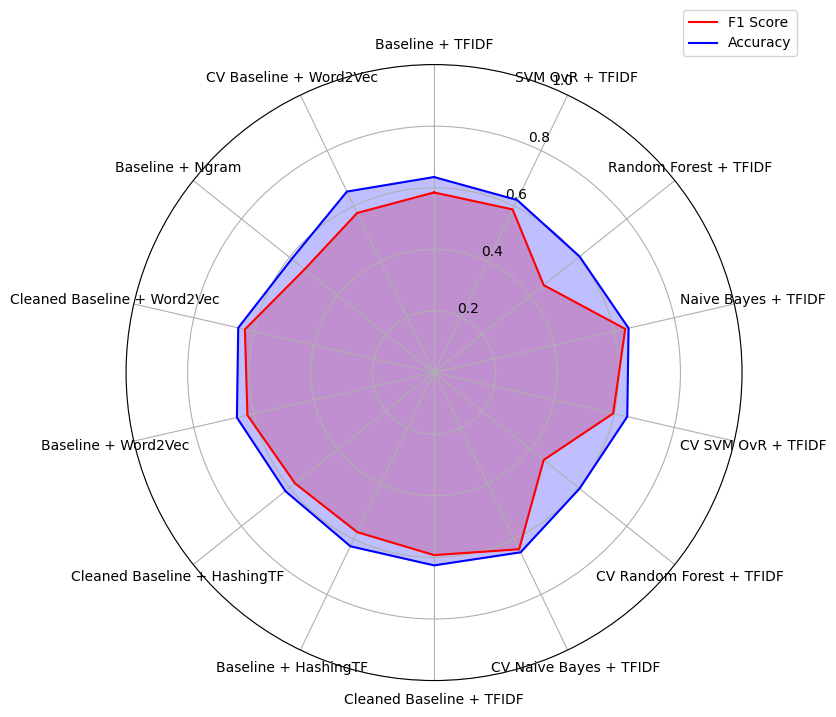

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

data = {
    'Baseline + TFIDF': {'F1': f1_baseline_tfidf, 'Accuracy': accuracy_baseline_tfidf},
    'SVM OvR + TFIDF': {'F1': f1_svm_ovr_tfidf, 'Accuracy': accuracy_svm_ovr_tfidf},
    'Random Forest + TFIDF': {'F1': f1_rf_tfidf, 'Accuracy': accuracy_rf_tfidf},
    'Naive Bayes + TFIDF': {'F1': f1_nb_tfidf, 'Accuracy': accuracy_nb_tfidf},
    'CV SVM OvR + TFIDF': {'F1': best_f1_svm_ovr_tfidf, 'Accuracy': best_accuracy_svm_ovr_tfidf},
    'CV Random Forest + TFIDF': {'F1': best_f1_rf_tfidf, 'Accuracy': best_accuracy_rf_tfidf},
    'CV Naive Bayes + TFIDF': {'F1': best_f1_nb_tfidf, 'Accuracy': best_accuracy_nb_tfidf},
    'Cleaned Baseline + TFIDF': {'F1': f1_cleaned_baseline_tfidf, 'Accuracy': accuracy_cleaned_baseline_tfidf},
    'Baseline + HashingTF': {'F1': f1_baseline_hashingtf, 'Accuracy': accuracy_baseline_hashingtf},
    'Cleaned Baseline + HashingTF': {'F1': f1_cleaned_baseline_hashingtf, 'Accuracy': accuracy_cleaned_baseline_hashingtf},
    'Baseline + Word2Vec': {'F1': f1_baseline_w2v, 'Accuracy': accuracy_baseline_w2v},
    'Cleaned Baseline + Word2Vec': {'F1': f1_cleaned_baseline_w2v, 'Accuracy': accuracy_cleaned_baseline_w2v},
    'Baseline + Ngram': {'F1': f1_baseline_ngrams, 'Accuracy': accuracy_baseline_ngrams},
    'CV Baseline + Word2Vec': {'F1': f1, 'Accuracy': accuracy}
}

labels=np.array(list(data.keys()))
stats=np.array(list(data.values()))

# create radar chart
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()

# data closure
stats=np.concatenate((stats,[stats[0]]))
angles+=angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, [d['F1'] for d in stats], color='red', alpha=0.25)
ax.plot(angles, [d['F1'] for d in stats], color='red', label='F1 Score')
ax.fill(angles, [d['Accuracy'] for d in stats], color='blue', alpha=0.25)
ax.plot(angles, [d['Accuracy'] for d in stats], color='blue', label='Accuracy')

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], labels)
ax.set_ylim(0,1)

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

# Explanation

First of all, to comprehensively understand and present the data, we employ a variety of visualization techniques, showcasing five different data statistics.

Visualization 1 is a pie chart to find the proportion of the three sentiments.

Visualization 2 draw a distribution histogram of comment length to observe the change and distribution of comment length.

Visualization 3 draw a word cloud to see the frequency of words clearly.

Visualization 4 shows the 10 most frequently occurring words in the Comment excluding stop words.

Visualization 5 shows the average length of reviews categorized by sentiments.

To optimize a data analytics project, we initiate by crafting a baseline model(logistic regression), to serve as our starting point without any advanced tuning. This foundational approach provides a basic framework for performance comparison.

Subsequently, we expand our analysis by incorporating four additional data analytics models: SVM with One-vs-Rest, Random Forest, Naive Bayes classifier.

Further refinement involves meticulously fine-tuning the hyperparameters of each model to unearth the optimal performance metrics by using Cross Validation. The performance has been improved to varying degrees, and the biggest improvement is SVM.

The final stage of our methodology involves exploring innovative strategies to augment the baseline model's performance. We have tried cleaning the 'Comment'. Then we tried Baseline model with HashingTF, Word2Vec and N-grams, and compare to the cleaned version. Finally, we used Cross Validation to find the optimal performance baseline model.

Visualization 6 compares the difference among all models f1-score and accuracy that we used. 'Naive Bayes + TFIDF' and 'Cleaned Baseline + Word2Vec' are the best.